# **Cookie Cats and Project Goal**

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats.

As players progress through the levels of the game, they will **occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress**. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.

# **Dataset and Variables**

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

* userid - a unique number that identifies each player.
* version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
* sum_gamerounds - the number of game rounds played by the player during the first week after installation
* retention_1 - did the player come back and play 1 day after installing?
* retention_7 - did the player come back and play 7 days after installing?
* When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40

In [10]:
# Importing pandas
import pandas as pd
import matplotlib.pyplot as plt

# Reading the data set
df = pd.read_csv("/content/cookie_cats.csv")

# Showing the first few rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# **Descriptive Statistics**

In [11]:
# Number of unique player
df["userid"].nunique()

90189

In [12]:
# Counting the number of players in each A/B group.
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


It looks like there is roughly the same number of players in each group, nice!

The focus of this analysis will be on how the gate placement affects player retention, but just for fun: Let's plot the distribution of the number of game rounds players played during their first week playing the game.

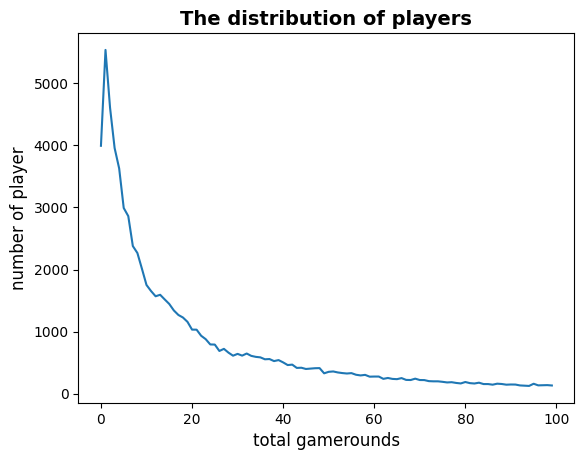

In [13]:
# The distribution of game rounds

# Counting the number of players for each number of gamerounds
plot_df = df.groupby("sum_gamerounds")["userid"].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot()
plt.title("The distribution of players", fontweight="bold", size=14)
plt.xlabel("total gamerounds", size=12)
plt.ylabel("number of player", size=12)
plt.show()

In the plot above we can see that some players install the game but then never play it (0 game rounds).

In [14]:
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

As a first step, let's look at what 1-day and 7-days retentions are overall.

In [15]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"1-day retention ratio: {round(df_retention[0],2)}% \
      \n7-days retention ratio: {round(df_retention[1],2)}%")

1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


In [16]:
# Calculating 1-day and 7-days retention for each A/B group
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


*   There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control group when it was at level 30 (44.8%).
*   Again,a decrease in 7-day retention when the gate was moved to level 40 (18.2%) compared to the control group when it was at level 30 (19.8%).

# **A/B Testing**

Testing Step:
1.   Creating samples of dataset (bootstraping)
2.   Calculating 1-day & 7-days retentions for A/B groups
3.   Plotting the bootstrap distributions
4.   Calculating retention rate difference between the two A/B groups
5.   Calculating the probability that 1-day & 7-days retentions are greater when the gate is at level 30
6.   Evaluating results and making recommendation






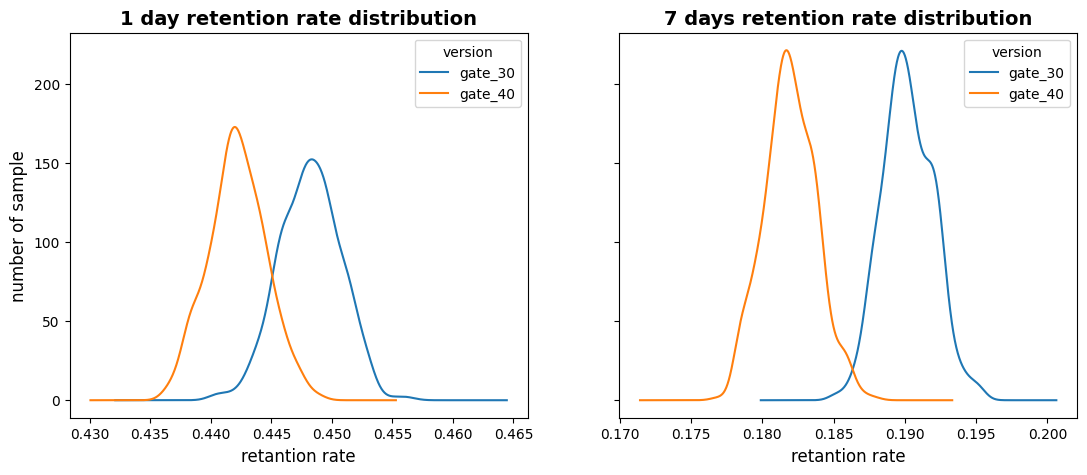

In [17]:
# Creating an list with bootstrapped means for each A/B group
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)

# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

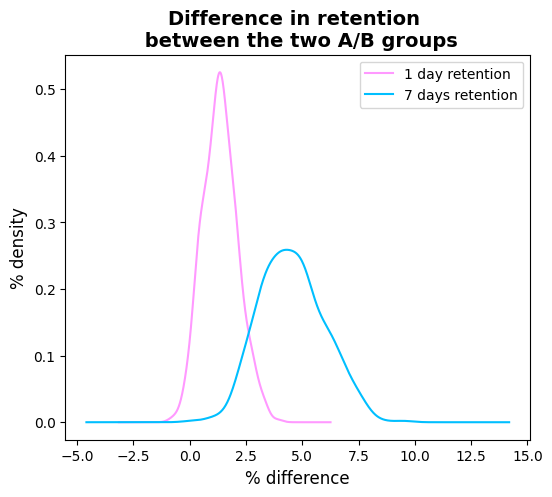

In [18]:
# Adding a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

From these chart, we can see that the most likely % difference is around 1% - 2% for 1-day retention. For 7-days retention the most likely % difference is around 2% - 5%. Moreover, the most of the distribution is above 0%, in favor of a gate at level 30.

In [19]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Calculating the probability that 7-days retention is greater when the gate is at level 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

# Pretty printing the probability
print(f"The probability that 1-day retention is greater when the gate is at level 30: {round(prob_1,2)*100}% \
      \nThe probability that 7-days retention is greater when the gate is at level 30: {(prob_7)*100}% ")

The probability that 1-day retention is greater when the gate is at level 30: 97.0%       
The probability that 7-days retention is greater when the gate is at level 30: 100.0% 


# Conclusions and Recommendation of the A/B-test

The bootstrap result tells us that there is strong evidence 99.8% probability that 7-day retention is higher when the gate is at level 30 than when it is at level 40.


*   Retention Day-1, The probability that the 1-Day retention will increase by moving the gate level to 40  is 0.037 and hence we will not recommend moving the gate

*   Retention Day-7, The probability that the 7-Day retention will increase by moving the gate level to 40  is 0.001 and hence we will not recommend moving the gate

If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics.